In [65]:
# stanのバージョンが v3.3 になり import pystan ではなくではなく import stan とライブラリ名がが
# 変わると当時に、build 時に以下のエラーがでるようになった。
# 対策としてnest_asyncio というライブラリを使う必要があるため、最初の一回のみライブラリをインストールしておくしておく
# 一回 install すれば、あとはこのコマンドは不要なので、先頭にに#をつけてコメントにしておいてください。
## RuntimeError: asyncio.run() cannot be called from a running event loop

!pip install nest_asyncio

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [66]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

from google.colab import drive
drive.mount('/content/drive')

input_dir = "/content/drive/MyDrive/input/"
output_dir = "/content/drive/MyDrive/output/"

# pystan と、パラメータの事後分布の推定結果を可視化するためのライブラリとして arviz を利用する。
import stan
import arviz
import nest_asyncio # stanのバージョンアップ対策
nest_asyncio.apply() # stanのバージョンアップ対策


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## デザイン行列を用いた単回帰

Stan による回帰モデル(デザイン行列ver.)の推定方法です。

In [67]:
!cat /content/drive/MyDrive/input/beer-sales-data.csv

sales,temperature
41.68,13.7
110.99,24
65.32,21.5
72.64,13.4
76.54,28.9
62.76,28.9
46.66,12.6
100.79,26.7
85.59,19.4
97.57,21
45.93,21.1
87.47,14.8
72.45,25.2
56.37,13.6
72.84,18.1
75.45,27.1
63.77,29.5
49.06,14.5
68.51,18.9
35.32,11.5
64.18,23.2
69.46,17.8
84.63,26.7
59.02,13
61.44,16.9
55.89,19.8
72.05,13
74.33,17.1
109.04,29.3
30.35,12.6
60.44,10.2
27.81,13.3
77.5,26.2
67.92,27.4
37.63,20.3
103.58,22.5
77.45,26.9
54.98,15.7
72.45,23.3
58.3,13
118.01,29.6
84.97,15.9
33,12.3
32.87,13.3
69.56,28.9
65.95,25.9
123.14,29.5
62.61,17
57.36,20
76.48,26.2
61.37,10.1
49.66,10.3
74.54,23.7
80.26,28.6
45.82,15.5
116.22,26.2
98.35,25.7
124.63,29.8
69.43,22.3
75.24,24.2
68.09,25.4
85.49,27.7
83.33,22.5
78.38,15.2
96.46,27.2
73.59,18.7
82.96,17.8
85.21,19.2
57.6,14.4
36.5,11.3
77.37,15.5
62.58,16.2
72.66,10.8
47.79,13.7
38.59,13.7
90.81,25.1
49.46,15.8
98.08,27.4
39.39,18.1
47.61,21.5
72.85,17
83.46,23.4
59.32,10.5
34.76,18
73.19,14
105.76,27.1
108.98,29.4
73.05,16.5
113.4,24.7
40.19,16.8
85,29.5
7

(100, 2)


,sales,temperature
0,41.68,13.7
1,110.99,24.0
2,65.32,21.5
3,72.64,13.4
4,76.54,28.9


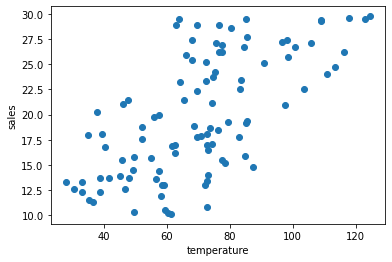

In [68]:
data = pd.read_csv(input_dir+'beer-sales-data.csv')

# len()でデータフレームの行数を取得
sample_size = len(data)

plt.scatter(data.sales, data.temperature)
plt.xlabel('temperature')
plt.ylabel('sales')

print(data.shape) # 次元を確認
data.head() # データの先頭を確認確認 data.tail() で後ろからも確認できる

In [69]:
# 目的変数をデータフレームから削除し、新規Xを作成 (xとyはのちの可視化のため変数として, Dと区別し保存しておく)
x = data.drop(['sales'], axis=1).values # 説明変数の抽出
y = data['sales'].values # 目的変数の抽出

# 目的変数をデータフレームから削除し、デザイン行列 D を作成
D = data.drop(['sales'], axis=1)
# 先頭列に値が1の(Intercept)を追加
D.insert(0, '(Intercept)', 1)

print (D.shape)
D.head()

(100, 2)


,(Intercept),temperature
0,1,13.7
1,1,24.0
2,1,21.5
3,1,13.4
4,1,28.9


In [70]:
# Stan に入力するデータを作成
stan_data = {
    'N': D.shape[0],
    'K': D.shape[1],
    'x': D.values, # DataFrame のままでは error がでるのでるのでるので values で抽出
    'y': y
}

stan_data

{'N': 100, 'K': 2, 'x': array([[ 1. , 13.7],
        [ 1. , 24. ],
        [ 1. , 21.5],
        [ 1. , 13.4],
        [ 1. , 28.9],
        [ 1. , 28.9],
        [ 1. , 12.6],
        [ 1. , 26.7],
        [ 1. , 19.4],
        [ 1. , 21. ],
        [ 1. , 21.1],
        [ 1. , 14.8],
        [ 1. , 25.2],
        [ 1. , 13.6],
        [ 1. , 18.1],
        [ 1. , 27.1],
        [ 1. , 29.5],
        [ 1. , 14.5],
        [ 1. , 18.9],
        [ 1. , 11.5],
        [ 1. , 23.2],
        [ 1. , 17.8],
        [ 1. , 26.7],
        [ 1. , 13. ],
        [ 1. , 16.9],
        [ 1. , 19.8],
        [ 1. , 13. ],
        [ 1. , 17.1],
        [ 1. , 29.3],
        [ 1. , 12.6],
        [ 1. , 10.2],
        [ 1. , 13.3],
        [ 1. , 26.2],
        [ 1. , 27.4],
        [ 1. , 20.3],
        [ 1. , 22.5],
        [ 1. , 26.9],
        [ 1. , 15.7],
        [ 1. , 23.3],
        [ 1. , 13. ],
        [ 1. , 29.6],
        [ 1. , 15.9],
        [ 1. , 12.3],
        [ 1. , 13.3],
        [

$
y = N(\mu, \sigma)\\
\mu = b_0 + b_1 x
$


In [71]:
stan_code = """
data {
  int N; // データ数
  int K; // デザイン行列の列数 (説明変数の数+1)
  matrix[N, K] x; // デザイン行列
  vector[N] y; // 目的変数。行列計算するときは、real や int ではなく、matrix と vector を使う必要があります。
}

parameters {
  vector[K] b; // 切片を含む係数ベクトル
  real<lower=0> sigma; // 標準偏差 <lower=0>は、0以上の値しか取らないという指定
}

model {
  vector[N] mu = x * b;
  for (i in 1:N) {
    y[i] ~ normal (mu[i], sigma); // 線形単回帰モデル, b0とb1の事前分布は定義していないので-∞から+∞の一様分布
  }
}
"""

In [72]:
model = stan.build(stan_code, data=stan_data, random_seed=1)
# MCMCの実行
fit = model.sample(
    num_warmup = 1000, # バーンイン期間
    num_chains = 4, #チェーン数
    num_samples= 2000, # 乱数生成の繰り返し回数
    num_thin = 1, #間引き数
)

Building...



Building: found in cache, done.Messages from stanc:
Sampling:   0%
Sampling: 100%, done.
Messages received during sampling:
  Gradient evaluation took 6.3e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.63 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 5.2e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.52 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 3e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.3 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 3.4e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.34 seconds.
  Adjust your expectations accordingly!


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
b[0],21.041,5.925,9.559,31.589,0.116,0.082,2602.0,3274.0,1.0
b[1],2.466,0.286,1.930,3.004,0.006,0.004,2587.0,3191.0,1.0
sigma,17.108,1.231,14.856,19.386,0.021,0.015,3502.0,3653.0,1.0


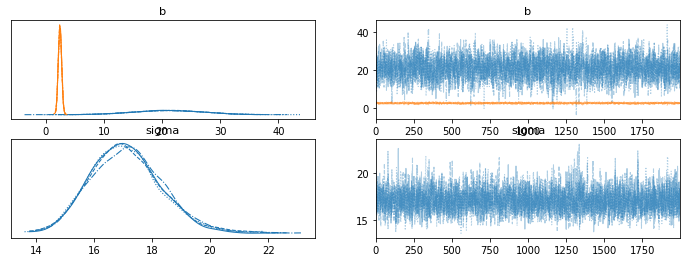

In [23]:
# MCMCの経過を簡易表示, muとsigmaのiter変化が見られる
arviz.plot_trace(fit)

#  Gelman-Rubin 統計量 (r_hat)、Highest density interval (HDI) などの簡易表示
summary = arviz.summary(fit)
summary

In [24]:
result = fit.to_frame()

# 統計量の概要を確認
print(result.describe().T)

# 先頭を表示
result.head()

                count        mean       std         min         25%  \
parameters                                                            
lp__           8000.0 -330.133736  1.225368 -338.467551 -330.664664   
accept_stat__  8000.0    0.931370  0.101809    0.144711    0.909185   
stepsize__     8000.0    0.213919  0.023214    0.180958    0.197949   
treedepth__    8000.0    3.244000  0.925646    1.000000    3.000000   
n_leapfrog__   8000.0   14.000500  8.202890    1.000000    7.000000   
divergent__    8000.0    0.000000  0.000000    0.000000    0.000000   
energy__       8000.0  331.603906  1.713503  328.672806  330.338912   
b.1            8000.0   21.041053  5.924795   -3.661664   17.030747   
b.2            8000.0    2.465990  0.286418    1.366956    2.271114   
sigma          8000.0   17.108126  1.230693   13.604372   16.247793   

                      50%         75%         max  
parameters                                         
lp__          -329.816825 -329.241408 -328.

parameters,lp__,accept_stat__,stepsize__,treedepth__,n_leapfrog__,divergent__,energy__,b.1,b.2,sigma
draws,,,,,,,,,,
0,-331.704815,0.996393,0.203612,4.0,15.0,0.0,333.715873,14.722441,2.586437,16.317168
1,-330.166114,0.861900,0.231902,4.0,15.0,0.0,331.898431,14.287324,2.884209,17.029772
2,-331.981044,1.000000,0.180958,3.0,7.0,0.0,332.034797,20.852979,2.271637,18.331906
3,-328.830296,0.999215,0.239203,4.0,15.0,0.0,329.681648,21.783201,2.476773,17.109376
4,-330.055359,1.000000,0.203612,3.0,11.0,0.0,332.090785,18.743814,2.699459,17.567483


In [26]:
# パラメータのトレースプロットと事後分布を可視化する関数を自作
def plot_trace(param, param_name='parameter'):  
  mean = np.mean(param) # 平均値（期待値） 
  median = np.median(param) # 中央値
  cred_min, cred_max = np.percentile(param, 2.5), np.percentile(param, 97.5) # 95%信頼区間
  
  # トレースプロット
  plt.plot(param)
  plt.xlabel('samples')
  plt.ylabel(param_name)
  plt.axhline(mean, color='red', linestyle='--')
  plt.axhline(median, color='black', linestyle='--')
  plt.axhline(cred_min, linestyle=':', color='gray') # 95%信頼区間の範囲を表記
  plt.axhline(cred_max, linestyle=':', color='gray')
  plt.title('Trace for ' + param_name)
  plt.show()

  # 事後分布
  plt.hist(param, 30, density=True)
  #sns.kdeplot(param, shade=True) # カーネル密度関数を可視化する。。seabornも使えるようになっていると素敵なグラフが作れる。
  plt.axvline(mean, color='red', linestyle='--',label='mean')
  plt.axvline(median, color='black', linestyle='--',label='median')
  plt.axvline(cred_min, linestyle=':', color='gray', label='95% CI') # 95%信頼区間の範囲を表記
  plt.axvline(cred_max, linestyle=':', color='gray')  
  plt.xlabel(param_name)
  plt.ylabel('density')
  plt.legend()
  plt.title('Posterior Distribution for ' + param_name)
  plt.show()

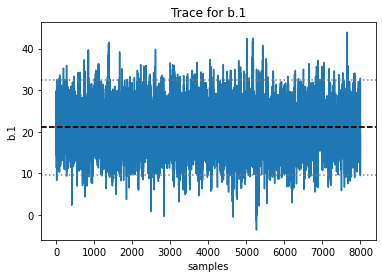

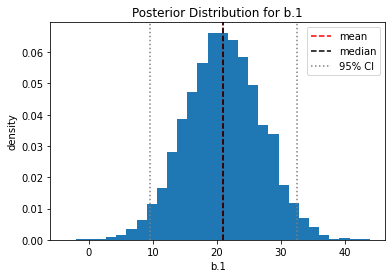

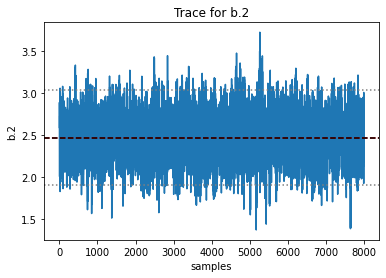

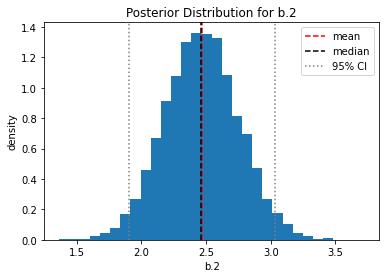

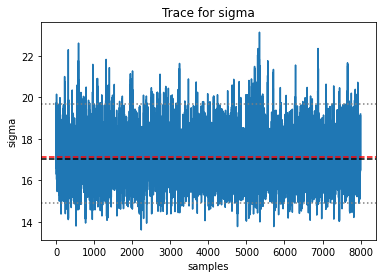

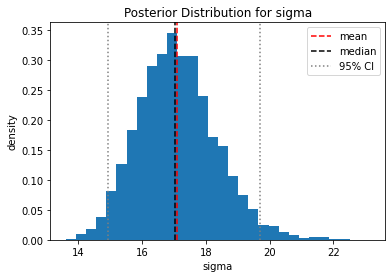

In [27]:
for name in ["b.1", "b.2", "sigma"]: # result の中で計算するパラメータを指定し、そのパラメータのトレースプロットと事後分布を個別に確認できる
  plot_trace(result[name], name)

In [33]:
# 参考：【pandas】filter：列の抽出【データフレーム処理】 https://datasciencemore.com/python-pandas-filter
# b1 と b2 を抽出する方法をテスト
# 正規表現を使って、、mu_predの後ろに 0-9 までの数字が続いたのちに終わる($)、列名 (axis=1) を抽出
print(result.filter(regex='b.[0-9]+$', axis=1))
b0, b1 = np.average(result.filter(regex='b.[0-9]+$', axis=1), axis=0) # (axix=0)列ごとに平均値を取得
print (b0, b1)

parameters        b.1       b.2
draws                          
0           14.722441  2.586437
1           14.287324  2.884209
2           20.852979  2.271637
3           21.783201  2.476773
4           18.743814  2.699459
...               ...       ...
7995        22.030643  2.427869
7996        13.409829  2.727415
7997        32.848273  1.920081
7998         9.415526  3.003350
7999        19.251872  2.617378

[8000 rows x 2 columns]
21.041052729934243 2.465989900382586


Text(0, 0.5, 'sales')

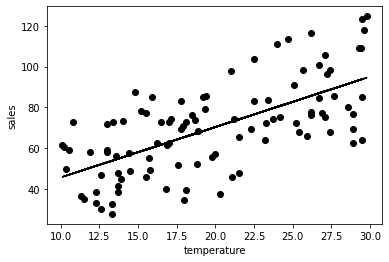

In [34]:
plt.scatter(x, y, color='black')
plt.plot(x, b0 + b1 * x, color='black')
plt.xlabel('temperature')
plt.ylabel('sales')


## デザイン行列を用いた単回帰(2)

Stan による単回帰モデルの推定で、デザイン行列を用いて予測を行う方法です。
ベクトルや行列演算になるところに注意が必要です。

In [35]:
x_pred = np.arange(10,41,1) # 予測データとして、10からから41未満の10刻みの等差数列を作成
print (x_pred)

# 予想データにも先頭列に値が1の(Intercept)を追加したデザイン行列を作成する
D_pred = pd.DataFrame(x_pred)
D_pred.insert(0, '(Intercept)', 1)

# Stan に入力するデータを新規作成
stan_data2 = {
    'N': D.shape[0],
    'K': D.shape[1],
    'x': D.values, 
    'y': y,
    'N_pred': D_pred.shape[0],
    'x_pred': D_pred.values,
}

stan_data2

[10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33
 34 35 36 37 38 39 40]


{'N': 100, 'K': 2, 'x': array([[ 1. , 13.7],
        [ 1. , 24. ],
        [ 1. , 21.5],
        [ 1. , 13.4],
        [ 1. , 28.9],
        [ 1. , 28.9],
        [ 1. , 12.6],
        [ 1. , 26.7],
        [ 1. , 19.4],
        [ 1. , 21. ],
        [ 1. , 21.1],
        [ 1. , 14.8],
        [ 1. , 25.2],
        [ 1. , 13.6],
        [ 1. , 18.1],
        [ 1. , 27.1],
        [ 1. , 29.5],
        [ 1. , 14.5],
        [ 1. , 18.9],
        [ 1. , 11.5],
        [ 1. , 23.2],
        [ 1. , 17.8],
        [ 1. , 26.7],
        [ 1. , 13. ],
        [ 1. , 16.9],
        [ 1. , 19.8],
        [ 1. , 13. ],
        [ 1. , 17.1],
        [ 1. , 29.3],
        [ 1. , 12.6],
        [ 1. , 10.2],
        [ 1. , 13.3],
        [ 1. , 26.2],
        [ 1. , 27.4],
        [ 1. , 20.3],
        [ 1. , 22.5],
        [ 1. , 26.9],
        [ 1. , 15.7],
        [ 1. , 23.3],
        [ 1. , 13. ],
        [ 1. , 29.6],
        [ 1. , 15.9],
        [ 1. , 12.3],
        [ 1. , 13.3],
        [

In [37]:
stan_code2 = """
data {
  int N; // 学習データ数
  int K; // デザイン行列の列数 (説明変数の数+1)
  matrix[N, K] x; // デザイン行列
  vector[N] y; // 目的変数。行列計算するときは、real や int ではなく、matrix と vector を使う必要があります。

  int N_pred;
  matrix[N_pred, K] x_pred; // 予測データ(デザイン行列)
}

parameters {
  vector[K] b; // 切片を含む係数ベクトル
  real<lower=0> sigma; // 標準偏差 <lower=0>は、0以上の値しか取らないという指定
}

model {
	vector[N] mu = x * b;
  y ~ normal(mu, sigma); // ベクトル処理して書くこともできて、こちらのほうが計算が早い。
}

generated quantities { // 推定したパラやデータをを使った操作を記述できる。乱数生成が許される唯一のブロック。このブロックでは　~ を使えないことに注意
  vector[N_pred] mu_pred = x_pred * b; // 期待値
  vector[N_pred] y_pred;  // 予測値

  for (i in 1:N_pred) {
    y_pred[i] = normal_rng(mu_pred[i], sigma); // ある分布から乱数を発生させたい場合は、分布名に _rng　をつける 
  }
}
"""

In [38]:
model2 = stan.build(stan_code2, data=stan_data2, random_seed=1)
# MCMCの実行
fit2 = model2.sample(
    num_warmup = 1000, # バーンイン期間
    num_chains = 4, #チェーン数
    num_samples= 2000, # 乱数生成の繰り返し回数
    num_thin = 1, #間引き数
)

Building...



Building: 39.0s, done.Messages from stanc:
Sampling:   0%
Sampling:  25% (3000/12000)
Sampling:  50% (6000/12000)
Sampling:  75% (9000/12000)
Sampling: 100% (12000/12000)
Sampling: 100% (12000/12000), done.
Messages received during sampling:
  Gradient evaluation took 4.2e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.42 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 1.5e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.15 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 1.2e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.12 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 1.8e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.18 seconds.
  Adjust your expectations accordingly!


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
b[0],21.137,5.932,10.623,32.582,0.109,0.077,2966.0,3595.0,1.0
b[1],2.462,0.288,1.913,2.991,0.005,0.004,3003.0,3372.0,1.0
sigma,17.097,1.237,14.883,19.436,0.021,0.015,3480.0,3449.0,1.0
mu_pred[0],45.756,3.275,39.428,51.718,0.058,0.041,3148.0,4083.0,1.0
mu_pred[1],48.218,3.032,42.986,54.397,0.053,0.038,3222.0,4208.0,1.0
...,...,...,...,...,...,...,...,...,...
y_pred[26],109.705,18.080,74.726,142.496,0.210,0.149,7426.0,7646.0,1.0
y_pred[27],112.202,18.136,79.572,147.875,0.214,0.152,7207.0,7119.0,1.0
y_pred[28],114.879,17.985,81.672,149.246,0.215,0.152,6987.0,7502.0,1.0
y_pred[29],117.328,18.045,83.100,151.805,0.214,0.152,7089.0,7444.0,1.0


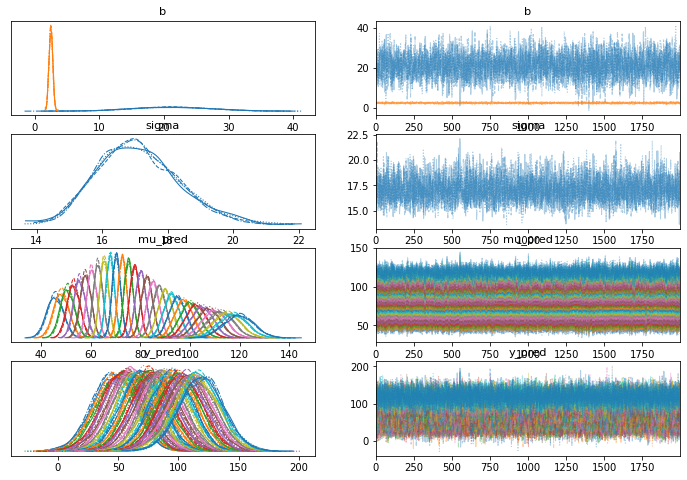

In [39]:
# MCMCの経過を簡易表示, muとsigmaのiter変化が見られる
arviz.plot_trace(fit2)

#  Gelman-Rubin 統計量 (r_hat)、Highest density interval (HDI) などの簡易表示
summary = arviz.summary(fit2)
summary

In [41]:
result2 = fit2.to_frame()
# ただし、mu_pred や y_pred が x_pred 別に計算されていることを確認
print (list(result2.columns)) #列名

# 統計量の概要を確認
print(result2.describe().T)

# 先頭を表示
result2.head()

['lp__', 'accept_stat__', 'stepsize__', 'treedepth__', 'n_leapfrog__', 'divergent__', 'energy__', 'b.1', 'b.2', 'sigma', 'mu_pred.1', 'mu_pred.2', 'mu_pred.3', 'mu_pred.4', 'mu_pred.5', 'mu_pred.6', 'mu_pred.7', 'mu_pred.8', 'mu_pred.9', 'mu_pred.10', 'mu_pred.11', 'mu_pred.12', 'mu_pred.13', 'mu_pred.14', 'mu_pred.15', 'mu_pred.16', 'mu_pred.17', 'mu_pred.18', 'mu_pred.19', 'mu_pred.20', 'mu_pred.21', 'mu_pred.22', 'mu_pred.23', 'mu_pred.24', 'mu_pred.25', 'mu_pred.26', 'mu_pred.27', 'mu_pred.28', 'mu_pred.29', 'mu_pred.30', 'mu_pred.31', 'y_pred.1', 'y_pred.2', 'y_pred.3', 'y_pred.4', 'y_pred.5', 'y_pred.6', 'y_pred.7', 'y_pred.8', 'y_pred.9', 'y_pred.10', 'y_pred.11', 'y_pred.12', 'y_pred.13', 'y_pred.14', 'y_pred.15', 'y_pred.16', 'y_pred.17', 'y_pred.18', 'y_pred.19', 'y_pred.20', 'y_pred.21', 'y_pred.22', 'y_pred.23', 'y_pred.24', 'y_pred.25', 'y_pred.26', 'y_pred.27', 'y_pred.28', 'y_pred.29', 'y_pred.30', 'y_pred.31']
                count        mean        std         min    

parameters,lp__,accept_stat__,stepsize__,treedepth__,n_leapfrog__,divergent__,energy__,b.1,b.2,sigma,...,y_pred.22,y_pred.23,y_pred.24,y_pred.25,y_pred.26,y_pred.27,y_pred.28,y_pred.29,y_pred.30,y_pred.31
draws,,,,,,,,,,,,,,,,,,,,,
0,-329.430418,0.999676,0.196114,4.0,23.0,0.0,331.872387,25.272970,2.348736,16.428184,...,108.162941,123.735958,101.584369,129.470804,116.731376,107.965335,128.404649,111.763145,116.243868,107.955871
1,-328.913146,1.000000,0.240636,2.0,7.0,0.0,329.934133,18.946426,2.538933,17.506411,...,87.162986,110.252441,113.672991,107.322189,141.531984,124.564388,105.626391,143.656668,91.383396,111.056400
2,-330.701267,0.999015,0.180066,2.0,7.0,0.0,331.201800,32.280282,1.889847,17.581381,...,122.948437,71.227455,73.921523,87.167583,110.492283,123.397113,90.288587,116.488954,98.960688,102.759605
3,-328.947229,0.848243,0.236149,3.0,15.0,0.0,329.597257,18.479527,2.636181,16.880380,...,84.913005,72.692301,123.646887,91.305461,104.244864,144.740183,105.750290,121.033592,109.283347,131.805683
4,-329.767273,0.987656,0.196114,3.0,15.0,0.0,330.960060,19.875805,2.609494,18.142571,...,89.585509,96.970530,111.321926,100.440495,104.802891,125.856371,55.745204,86.623798,141.637745,112.745266


In [45]:
# 回帰直線（平均値）の95%ベイズ信用区間を確認。note6-1と同じ結果になっていることを確認すること。すること。
mu_pred_95 = np.quantile(result2.filter(regex='mu_pred.[0-9]+$', axis=1),axis=0, q=[0.025,0.975]) 
mu_pred_mean = np.average(result2.filter(regex='mu_pred.[0-9]+$', axis=1), axis=0) # (axix=0)列ごとに平均値を取得
print (mu_pred_95)
print (mu_pred_mean)

# 予測値の95%ベイズ信用区間（予測区間）の算出。note6-1と同じ結果になっていることを確認すること。
y_pred_95 = np.quantile(result2.filter(regex='y_pred.[0-9]+$', axis=1),axis=0, q=[0.025,0.975]) # 事後予測分布の95%信頼区間を x_pred の数分だけ抽出
y_pred_mean = np.average(result2.filter(regex='y_pred.[0-9]+$', axis=1), axis=0) # (axix=0)列ごとに平均値を取得
print (y_pred_95)
print (y_pred_mean)

[[ 39.32920055  42.24275384  45.20986753  48.08472277  50.94839381
   53.79442015  56.59129695  59.37018789  62.02104161  64.58475387
   67.04493864  69.45349606  71.73066179  73.93945056  76.14655979
   78.24418107  80.32121121  82.38898173  84.36735969  86.38217624
   88.34980864  90.34614531  92.31483446  94.26351477  96.22562496
   98.16003484 100.11291076 102.05177868 103.90464862 105.82545781
  107.76093485]
 [ 52.15840202  54.12592381  56.15097293  58.19029275  60.22174555
   62.3302066   64.43797124  66.6474401   68.9196016   71.3127282
   73.78398113  76.29748869  78.90419313  81.55797974  84.27261459
   87.07007761  89.93860026  92.84804632  95.74876639  98.67693091
  101.61104761 104.59484834 107.61082423 110.54621889 113.53356024
  116.53593421 119.5204431  122.5586871  125.58804939 128.60300542
  131.63372107]]
[ 45.75599125  48.2179136   50.67983595  53.1417583   55.60368065
  58.06560299  60.52752534  62.98944769  65.45137004  67.91329239
  70.37521474  72.83713709  75.2

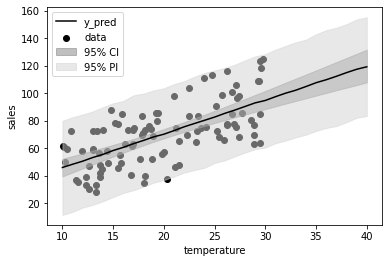

In [55]:
plt.scatter(x, y, color='black', label="data")
plt.plot(x_pred, y_pred_mean, color='black', label='y_pred')
plt.fill_between(x_pred, mu_pred_95[0], mu_pred_95[1], color='gray', alpha=0.5, label='95% CI')
plt.fill_between(x_pred, y_pred_95[0], y_pred_95[1], color='lightgray', alpha=0.5, label='95% PI')
plt.xlabel('temperature')
plt.ylabel('sales')
plt.legend()